# NCAA ML Competition - Women's 2018

## Notes

Notes about what's in the data files: https://www.kaggle.com/c/womens-machine-learning-competition-2018/data

Starter Kernel might help: https://www.kaggle.com/juliaelliott/basic-starter-kernel-ncaa-women-s-dataset

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV


# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

/Users/chenyingcharlene/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/chenyingcharlene/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Load Data

In [2]:
# update this as needed!

# right now, only looking at tournament seed / performance, not regular season games
data_dir = './WDataFiles/'
data_dir_1 = './WPrelimData2018/'
df_seeds = pd.read_csv(data_dir + 'WNCAATourneySeeds.csv')
df_tour_compact = pd.read_csv(data_dir_1 + 'WNCAATourneyCompactResults_PrelimData2018.csv')

df_tour = pd.read_csv(data_dir_1 + 'WNCAATourneyDetailedResults_PrelimData2018.csv')
df_reg_compact = pd.read_csv(data_dir_1+'WRegularSeasonCompactResults_PrelimData2018.csv')

df_reg_detail = pd.read_csv('./WPrelimData2018/WRegularSeasonDetailedResults_PrelimData2018.csv')

df_teams = pd.read_csv(data_dir + 'WTeams.csv')

In [3]:
# Add winning an losing team names to the regular compact and tour compact dataframes

df_teams_w = df_teams.rename(columns={'TeamID':'WTeamID','TeamName':'WTeamName'})
df_teams_l = df_teams.rename(columns={'TeamID':'LTeamID','TeamName':'LTeamName'})

df_reg_compact = pd.merge(left=df_reg_compact, right=df_teams_w, how='left', on=['WTeamID'])
df_reg_compact = pd.merge(left=df_reg_compact, right=df_teams_l, how='left', on=['LTeamID'])
df_reg_compact.head()

df_tour_compact = pd.merge(left=df_tour_compact, right=df_teams_w, how='left', on=['WTeamID'])
df_tour_compact = pd.merge(left=df_tour_compact, right=df_teams_l, how='left', on=['LTeamID'])



In [4]:
# Get the top 15 teams that are seeded No 1

df_seeds['SeedNo'] = df_seeds.loc[:,['Seed']].apply(lambda x: x['Seed'][-1:] ,axis=1)

df_seeds = pd.merge(left=df_seeds, right=df_teams, how='left', on=['TeamID'])


df_seeds.loc[df_seeds.SeedNo == '1',:]

df_teams_seed_count = pd.DataFrame({'count':df_seeds.loc[df_seeds.SeedNo == '1',:].groupby(['TeamID','TeamName']).size()}).reset_index()

df_teams_seed_count_top_15 = df_teams_seed_count.nlargest(15,'count').sort_values('count',axis=0,ascending=False)


In [5]:
# Get the top 15 teams that have won the maximum number of regular season games

df_reg_compact_team_wins = df_reg_compact[['WTeamName','WTeamID']]

df_reg_compact_team_wins = pd.DataFrame({'count':df_reg_compact_team_wins.groupby(['WTeamID','WTeamName']).size()}).reset_index()

df_reg_compact_team_wins_top_15 = df_reg_compact_team_wins.nlargest(15,'count').sort_values('count',axis=0,ascending=False)

In [6]:
# Get the top 15 teams that have won the maximum number of tour season games

df_tour_compact_team_wins = df_tour_compact[['WTeamName','WTeamID']]

df_tour_compact_team_wins = pd.DataFrame({'count':df_tour_compact_team_wins.groupby(['WTeamID','WTeamName']).size()}).reset_index() \
.rename(columns={'WTeamID':'TeamID','WTeamName':'TeamName'})

df_tour_compact_team_wins_top_15 = df_tour_compact_team_wins.nlargest(15,'count').sort_values('count',axis=0,ascending=False)


In [7]:
# Get the top teams that have won the maximum number of NCAA championships


df_tour_compact.sort_values(['Season', 'DayNum'], inplace=True)
    
df_tour_compact_champs = df_tour_compact.drop_duplicates(['Season'], keep='last', inplace=False)

df_tour_compact_champs = pd.DataFrame({'count':df_tour_compact_champs.groupby(['WTeamID','WTeamName']).size()}).reset_index() \
.rename(columns={'WTeamID':'TeamID','WTeamName':'TeamName'})


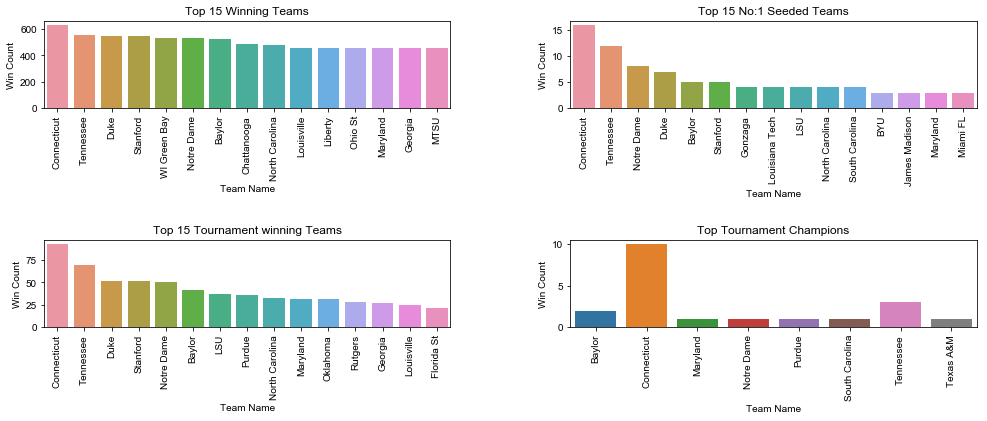

In [8]:
# Set up the figure,axes and style for the plots
fig, axes = plt.subplots(nrows=2,ncols=2, sharey=False)
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5)
fig.set_size_inches(15, 5, forward=True)
sns.set_style("whitegrid")

# Plot a barplot for Top 15 Winning Teams
ax = sns.barplot(x="WTeamName", y="count", data=df_reg_compact_team_wins_top_15,ax=axes[0,0])
ax.set(xlabel='Team Name', ylabel='Win Count')
ax.set_title('Top 15 Winning Teams')

for item in ax.get_xticklabels():
    item.set_rotation(90)

# Plot a barplot for Top 15 No:1 Seeded Teams

ax1 = sns.barplot(x="TeamName", y="count", data=df_teams_seed_count_top_15,ax=axes[0,1])
ax1.set(xlabel='Team Name', ylabel='Win Count')
ax1.set_title('Top 15 No:1 Seeded Teams')


for item in ax1.get_xticklabels():
    item.set_rotation(90)
    
# Plot a barplot for Top 15 Tournament winning Teams

ax1 = sns.barplot(x="TeamName", y="count", data=df_tour_compact_team_wins_top_15,ax=axes[1,0])
ax1.set(xlabel='Team Name', ylabel='Win Count')
ax1.set_title('Top 15 Tournament winning Teams')


for item in ax1.get_xticklabels():
    item.set_rotation(90)
    
# Plot a barplot for Top Tournament Champions

ax1 = sns.barplot(x="TeamName", y="count", data=df_tour_compact_champs,ax=axes[1,1])
ax1.set(xlabel='Team Name', ylabel='Win Count')
ax1.set_title('Top Tournament Champions')


for item in ax1.get_xticklabels():
    item.set_rotation(90)



# Indicators of Regular Season Success

Let’s now turn to the regular season game statistics. We are interested in knowing how certain statistics correlate with winning vs losing. We will take the regular season detail and first convert it to a more ‘long’ format with only 1 column of TeamIDs and a factor indicating whether that row corresponds to a win or a loss. Here I also add some additional game statistcs. These include field goal percentage, free throw percentage, offensive/defensive rebounding efficiency, and possessions. 

In [9]:
# Calculate additional metrics for the winning team

# Calculate Field Goal Percentage 

df_reg_detail['WFGP'] = df_reg_detail.WFGM / df_reg_detail.WFGA

# Calculate 2Pt Field Goal Percentage

df_reg_detail['WFGP2'] = (df_reg_detail.WFGM - df_reg_detail.WFGM3) / (df_reg_detail.WFGA - df_reg_detail.WFGA3)

# Calculate 3Pt Field Goal Percentage

df_reg_detail['WFGP3'] = df_reg_detail.WFGM3 / df_reg_detail.WFGA3

# Calculate Free Throw Shooting

df_reg_detail['WFTP'] = df_reg_detail.WFTM / df_reg_detail.WFTA

# Calculate Offensive Rebounding Efficiency

df_reg_detail['WORP'] = df_reg_detail.WOR / (df_reg_detail.WOR + df_reg_detail.LDR)

# Calculate Defensive Rebounding Efficiency

df_reg_detail['WDRP'] = df_reg_detail.WDR / (df_reg_detail.WDR + df_reg_detail.LOR)

# Calculate Possessions

df_reg_detail['WPOS'] = 0.96 * (df_reg_detail.WFGA + df_reg_detail.WTO + 0.44 * df_reg_detail.WFTA - df_reg_detail.WOR)

In [10]:
# Calculate additional metrics for the Losing team

# Calculate Field Goal Percentage 

df_reg_detail['LFGP'] = df_reg_detail.LFGM / df_reg_detail.LFGA

# Calculate 2Pt Field Goal Percentage

df_reg_detail['LFGP2'] = (df_reg_detail.LFGM - df_reg_detail.LFGM3) / (df_reg_detail.LFGA - df_reg_detail.LFGA3)

# Calculate 3Pt Field Goal Percentage

df_reg_detail['LFGP3'] = df_reg_detail.LFGM3 / df_reg_detail.LFGA3

# Calculate Free Throw Shooting

df_reg_detail['LFTP'] = df_reg_detail.LFTM / df_reg_detail.LFTA

# Calculate Offensive Rebounding Efficiency

df_reg_detail['LORP'] = df_reg_detail.LOR / (df_reg_detail.LOR + df_reg_detail.LDR)

# Calculate Defensive Rebounding Efficiency

df_reg_detail['LDRP'] = df_reg_detail.LDR / (df_reg_detail.LDR + df_reg_detail.LOR)

# Calculate Possessions

df_reg_detail['LPOS'] = 0.96 * (df_reg_detail.LFGA + df_reg_detail.LTO + 0.44 * df_reg_detail.LFTA - df_reg_detail.LOR)

In [11]:
df_reg_detail.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,WORP,WDRP,WPOS,LFGP,LFGP2,LFGP3,LFTP,LORP,LDRP,LPOS
0,2010,11,3103,63,3237,49,H,0,23,54,...,0.270270,0.702703,67.5456,0.370370,0.414634,0.230769,0.600000,0.289474,0.710526,67.5840
1,2010,11,3104,73,3399,68,N,0,26,62,...,0.380952,0.688889,75.1872,0.396825,0.500000,0.190476,0.518519,0.350000,0.650000,77.6448
2,2010,11,3110,71,3224,59,A,0,29,62,...,0.378378,0.575000,63.6288,0.327586,0.386364,0.142857,0.826087,0.425000,0.575000,63.4752
3,2010,11,3111,63,3267,58,A,0,27,52,...,0.214286,0.645161,73.8816,0.243243,0.250000,0.230769,0.640000,0.500000,0.500000,71.0400
4,2010,11,3119,74,3447,70,H,1,30,74,...,0.304348,0.611111,72.8064,0.337838,0.280702,0.529412,0.523810,0.396226,0.603774,73.1904


Here is the start for PCA analysis.

In [12]:
# extract data set only for PCA

#Win_F_pca = list(["WFGP","WFGP2", "WFGP3", "WFTP", "WORP", "WDRP", "WPOS", "WAst", "WStl", "WBlk", "WPF"])
#Loss_F_pca = list(["LFGP","LFGP2", "LFGP3", "LFTP", "LORP", "LDRP", "LPOS", "LAst", "LStl", "LBlk", "LPF"])

Win_F_pca = list(["WFGP","WFGP2", "WORP", "WDRP", "WPOS", "WAst", "WStl", "WBlk", "WPF"])
Loss_F_pca = list(["LFGP","LFGP2", "LORP", "LDRP", "LPOS", "LAst", "LStl", "LBlk", "LPF"])

df_reg_detail_winners_pca = df_reg_detail.loc[:,Win_F_pca]
df_reg_detail_losers_pca = df_reg_detail.loc[:,Loss_F_pca]

In [13]:
# Normalize data (got issue)
from sklearn import preprocessing

df_reg_detail_winners_pca_scaled = df_reg_detail_winners_pca
df_reg_detail_losers_pca_scaled = df_reg_detail_losers_pca

for i in Win_F_pca:
    df_reg_detail_winners_pca_scaled[i] = preprocessing.scale(df_reg_detail_winners_pca[i])
    
for i in Loss_F_pca:
    df_reg_detail_losers_pca_scaled[i] = preprocessing.scale(df_reg_detail_losers_pca[i])

/Users/chenyingcharlene/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [14]:
#get the cov matrix
df_reg_w_covar = df_reg_detail_winners_pca_scaled.cov()
df_reg_l_covar = df_reg_detail_losers_pca_scaled.cov()

df_reg_w_covar.head()

,WFGP,WFGP2,WORP,WDRP,WPOS,WAst,WStl,WBlk,WPF
WFGP,1.000022,0.849768,-0.011322,0.006132,0.098517,0.521966,-0.022434,0.043749,0.006937
WFGP2,0.849768,1.000022,-0.004125,0.025409,0.094343,0.430799,0.007237,0.045506,-0.003548
WORP,-0.011322,-0.004125,1.000022,0.021841,-0.018816,0.115908,0.094954,0.061897,0.008535
WDRP,0.006132,0.025409,0.021841,1.000022,0.017365,0.065377,-0.143256,-0.114787,-0.127109
WPOS,0.098517,0.094343,-0.018816,0.017365,1.000022,0.258910,0.319103,0.116791,0.383136


In [15]:
df_reg_l_covar.head()

,LFGP,LFGP2,LORP,LDRP,LPOS,LAst,LStl,LBlk,LPF
LFGP,1.000022,0.855000,-0.278475,0.278475,0.094962,0.511744,-0.077667,0.013345,0.094431
LFGP2,0.855000,1.000022,-0.237666,0.237666,0.087602,0.398804,-0.045545,0.014951,0.084290
LORP,-0.278475,-0.237666,1.000022,-1.000022,-0.016179,-0.037348,0.237145,-0.052354,0.056279
LDRP,0.278475,0.237666,-1.000022,1.000022,0.016179,0.037348,-0.237145,0.052354,-0.056279
LPOS,0.094962,0.087602,-0.016179,0.016179,1.000022,0.228979,0.312651,0.090793,0.396053


In [16]:
#total variance
print(np.trace(df_reg_w_covar),np.trace(df_reg_l_covar))

9.00019894339 9.00019894339


In [17]:
#fit pca
from sklearn.decomposition import PCA

pca = PCA()
df_reg_detail_winners_pca_scaled_tran = pca.fit_transform(df_reg_detail_winners_pca_scaled)

pca_l = PCA()
df_reg_detail_losers_pca_scaled_tran = pca_l.fit_transform(df_reg_detail_losers_pca_scaled)

In [18]:
#new cov
new_df_reg_w_covar = np.round(pd.DataFrame(df_reg_detail_winners_pca_scaled_tran).cov(), 10)
new_df_reg_l_covar = np.round(pd.DataFrame(df_reg_detail_losers_pca_scaled_tran).cov(), 10)

new_df_reg_w_covar.head()

,0,1,2,3,4,5,6,7,8
0,2.30266,0.000000,-0.000000,-0.000000,-0.000000,0.0,0.0,-0.0,0.0
1,0.00000,1.561199,-0.000000,0.000000,-0.000000,0.0,0.0,0.0,-0.0
2,-0.00000,-0.000000,1.109856,0.000000,-0.000000,0.0,-0.0,-0.0,0.0
3,-0.00000,0.000000,0.000000,1.062532,0.000000,-0.0,0.0,0.0,-0.0
4,-0.00000,-0.000000,-0.000000,0.000000,0.935624,-0.0,0.0,-0.0,-0.0


In [19]:
new_df_reg_l_covar.head()

,0,1,2,3,4,5,6,7,8
0,2.662143,-0.000000,0.000000,-0.000000,0.000000,0.0,-0.0,0.0,0.0
1,-0.000000,1.896138,0.000000,-0.000000,-0.000000,-0.0,0.0,-0.0,-0.0
2,0.000000,0.000000,1.333709,-0.000000,-0.000000,0.0,0.0,0.0,0.0
3,-0.000000,-0.000000,-0.000000,0.985907,0.000000,-0.0,0.0,0.0,-0.0
4,0.000000,-0.000000,-0.000000,0.000000,0.862137,0.0,0.0,0.0,0.0


In [20]:
#total new variance
print (np.trace(new_df_reg_w_covar),np.trace(new_df_reg_w_covar))

9.0001989433 9.0001989433


In [21]:
pca.explained_variance_

array([ 2.30265958,  1.56119856,  1.10985637,  1.06253166,  0.93562435,
        0.89190305,  0.57297708,  0.42324871,  0.14019958])

In [22]:
pca_l.explained_variance_

array([  2.66214259e+00,   1.89613808e+00,   1.33370900e+00,
         9.85906699e-01,   8.62136685e-01,   6.70973524e-01,
         4.57514300e-01,   1.31678076e-01,   1.74623875e-31])

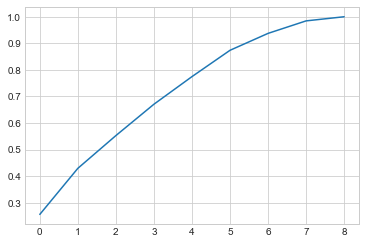

In [23]:
#plot winer features

import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca.explained_variance_ratio_))

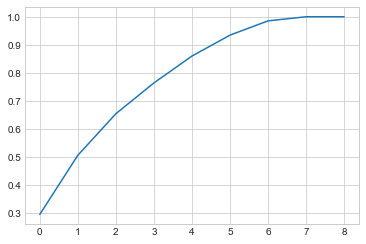

In [24]:
#plot loser features

plt.plot(np.cumsum(pca_l.explained_variance_ratio_))

In [25]:
num_comp = np.sum(np.cumsum(pca.explained_variance_ratio_) < .9)
num_comp_l = np.sum(np.cumsum(pca_l.explained_variance_ratio_) < .9)

print(num_comp, "and", num_comp_l,"out of ", len(Win_F_pca))
#not a good case to do the PCA

6 and 5 out of  9
